In [ ]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import random
import cv2

Mounting the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Creating a dictionary for finding the specific locations to analyze

In [ ]:
with open('/content/drive/MyDrive/APS360ProjectData/train_box_locations.json', 'r') as info_on:
  iterator_for = json.load(info_on)

In [ ]:
global_id = {}
for image in iterator_for['images']:
  global_id[image['file_name']] = image['id']

In [ ]:
info_with_id = {}
for annotation in iterator_for['annotations']:
  image_id = annotation['image_id']
  current_info = {'id': annotation['id'], 'bbox': annotation['bbox']}

  if image_id in info_with_id:
    info_with_id[image_id].append(current_info)
  else:
    info_with_id[image_id] = [current_info]

Example of Use:

In [ ]:
current_image_path = '/content/drive/MyDrive/APS360ProjectData/train/levle2_136_jpg.rf.fcbb097ebfaa42bb65a15f1824392f6f.jpg'
id_of_image = global_id['levle2_136_jpg.rf.fcbb097ebfaa42bb65a15f1824392f6f.jpg']
print(id_of_image)

4


In [ ]:
for info in info_with_id[id_of_image]:
  print("Current ID of the Box", info['id'], "Box Info", info['bbox'])
  print(info['bbox'][3])

Current ID of the Box 17 Box Info [1757, 2151, 138, 138]
138
Current ID of the Box 18 Box Info [1565, 2166, 77, 161]
161
Current ID of the Box 19 Box Info [1611, 1921, 153, 161]
161
Current ID of the Box 20 Box Info [1266, 2197, 207, 161]
161
Current ID of the Box 21 Box Info [845, 2580, 191, 146]
146
Current ID of the Box 22 Box Info [278, 2404, 99, 92]
92
Current ID of the Box 23 Box Info [247, 2511, 92, 115]
115
Current ID of the Box 24 Box Info [347, 2511, 115, 92]
92
Current ID of the Box 25 Box Info [354, 2664, 123, 92]
92
Current ID of the Box 26 Box Info [561, 2212, 69, 130]
130
Current ID of the Box 27 Box Info [646, 2113, 91, 69]
69
Current ID of the Box 28 Box Info [699, 2266, 100, 145]
145
Current ID of the Box 29 Box Info [898, 2312, 16, 30]
30
Current ID of the Box 30 Box Info [799, 2228, 99, 137]
137
Current ID of the Box 31 Box Info [707, 2480, 107, 77]
77
Current ID of the Box 32 Box Info [1649, 1408, 138, 115]
115
Current ID of the Box 33 Box Info [1557, 871, 85, 77]


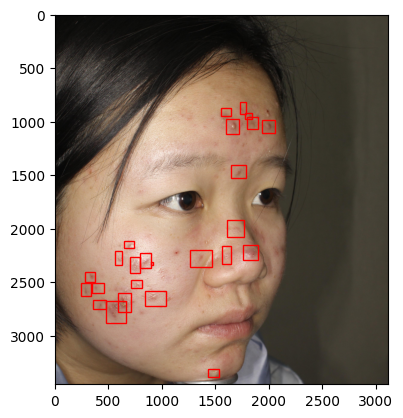

In [ ]:
current_image = Image.open(current_image_path)
figure, axis = plt.subplots(1)

axis.imshow(current_image)

for asd in info_with_id[id_of_image]:
  bbox = asd['bbox']
  x, y, w, h = bbox
  rectangle_box = patches.Rectangle((x,y,), w, h, linewidth=1, edgecolor='r', facecolor='none')
  axis.add_patch(rectangle_box)

plt.show()

As an example, analyzed an image of with name of "levle2_136_jpg.rf.fcbb097ebfaa42bb65a15f1824392f6f.jpg", and id of 4. It has 25 boxes on the image, and the dictionary contains the same info as expected.

Determining the average size of the boxes:



In [ ]:
average_width = 0
average_height = 0
counter = 0
current_files = os.listdir('/content/drive/MyDrive/APS360ProjectData/train')
for name in current_files:
  #current_image = Image.open('/content/drive/MyDrive/APS360ProjectData/train/' + name)
  id_of_image = global_id[name]
  for info in info_with_id[id_of_image]:
    info_on_boxes = info['bbox']
    x, y, w, h = info_on_boxes
    average_width += w
    average_height += h
    counter += 1


average_width = average_width/counter
average_height = average_height/counter

print(average_width)
print(average_height)

91.33194101639137
91.23277007784317


Given that the average height/width of boxes is around 91, the input size of images to the model will be 100.

The proposed architecture has to support images of input size of 100x100. Furthermore, due to the success of the VGG model, the group decided to use 3x3 convolution, since these filters can approximate any larger convolution effectively.

In [ ]:
class FinalAcneIdentification(nn.Module):
    def __init__(self):
        super(FinalAcneIdentification, self).__init__()
        self.name = "Final_Acne"
        self.conv1_first = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.conv1_second = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2) #50

        self.conv2_first = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv2_second = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2) #25

        self.conv3_first = nn.Conv2d(64, 128, 4, stride=1, padding=1)
        self.conv3_second = nn.Conv2d(128, 128, 4, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2) #11

        self.conv4_first = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv4_second = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2) #5

        self.fc1 = nn.Linear(256*5*5, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 1)


    def forward(self, x):
        x = F.relu(self.conv1_first(x))
        x = F.relu(self.conv1_second(x))
        x = self.pool1(x)

        x = F.relu(self.conv2_first(x))
        x = F.relu(self.conv2_second(x))
        x = self.pool2(x)

        x = F.relu(self.conv3_first(x))
        x = F.relu(self.conv3_second(x))
        x = self.pool3(x)

        x = F.relu(self.conv4_first(x))
        x = F.relu(self.conv4_second(x))
        x = self.pool4(x)

        x = x.view(-1, 256*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze(1)

        return x

Generating Dataset using INTER_LANCZOS4 interpolation for high quality of images

In [ ]:
current_files = os.listdir('/content/drive/MyDrive/APS360ProjectData/rcnn_train/acne')

for name in current_files:
  currena_im = cv2.imread('/content/drive/MyDrive/APS360ProjectData/rcnn_train/acne/' + name)
  if currena_im is None:
    break;
  resized_image = cv2.resize(currena_im, (100, 100), interpolation=cv2.INTER_LANCZOS4)
  output_dir = '/content/drive/MyDrive/APS360ProjectData/rcnn_train_INTER_LANCZOS4/acne/'
  cv2.imwrite(output_dir+name, resized_image)

In [ ]:
directory_containing_acne_files = os.listdir('/content/drive/MyDrive/APS360ProjectData/rcnn_train_INTER_LANCZOS4/acne')
print(len(directory_containing_acne_files))

1322


In [ ]:
directory_containing_non_acne_files = os.listdir('/content/drive/MyDrive/APS360ProjectData/rcnn_train_INTER_LANCZOS4/non_acne')
print(len(directory_containing_acne_files))

1322


Having a balanced dataset is critical to prevent the model from overfitting

In [ ]:
def get_relevant_indices(dataset, classes, target_classes):

    indices = []
    for i in range(len(dataset)):
        label_index = dataset[i][1]
        label_class = classes[label_index]
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    classes = ('acne', 'non_acne')
    targ_size = (124, 1)

    transform_app = transforms.Compose([transforms.Resize(targ_size),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]);

    trainset = datasets.ImageFolder('/content/drive/MyDrive/APS360ProjectData/rcnn_train_124', transform_app)

    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    np.random.seed(1000)
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8)

    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    return train_loader, val_loader, classes

def get_model_name(name, batch_size, learning_rate, epoch):

    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):

    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):

    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def plot_training_curve(path):

    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    target_classes = ["acne", "non_acne"]
    torch.manual_seed(1000)
    train_loader, val_loader, classes = get_data_loader(
            target_classes, batch_size)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            labels = normalize_label(labels)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
model_trained_on_inter_lancoz = FinalAcneIdentification()
train_net(model_trained_on_inter_lancoz, batch_size=611, learning_rate=0.05, num_epochs=10)

Epoch 1: Train err: 0.505671077504726, Train loss: 0.6932003796100616 |Validation err: 0.4782608695652174, Validation loss: 0.6931012868881226
Epoch 2: Train err: 0.5146502835538752, Train loss: 0.6931480914354324 |Validation err: 0.5217391304347826, Validation loss: 0.6932682394981384
Epoch 3: Train err: 0.4943289224952741, Train loss: 0.6930159032344818 |Validation err: 0.5217391304347826, Validation loss: 0.693473219871521
Epoch 4: Train err: 0.4943289224952741, Train loss: 0.6930475533008575 |Validation err: 0.5217391304347826, Validation loss: 0.6938914060592651
Epoch 5: Train err: 0.4943289224952741, Train loss: 0.693035215139389 |Validation err: 0.5217391304347826, Validation loss: 0.6941853165626526
Epoch 6: Train err: 0.4943289224952741, Train loss: 0.6928446441888809 |Validation err: 0.5217391304347826, Validation loss: 0.6941915154457092
Epoch 7: Train err: 0.4943289224952741, Train loss: 0.693272277712822 |Validation err: 0.5217391304347826, Validation loss: 0.6942554116249

The validation accuracy was 0.47826087. Parameters: batch_size = 611, learning_rate = 0.05, and num_epochs = 10. File Saved as: model_Final_Acne_bs611_lr0.05_epoch9

In [ ]:
model_trained_on_inter_lancoz = FinalAcneIdentification()
train_net(model_trained_on_inter_lancoz, batch_size=256, learning_rate=0.05, num_epochs=10)

Epoch 1: Train err: 0.4943289224952741, Train loss: 0.6933428976270888 |Validation err: 0.5217391304347826, Validation loss: 0.6935765544573466
Epoch 2: Train err: 0.4886578449905482, Train loss: 0.6931150356928507 |Validation err: 0.5217391304347826, Validation loss: 0.6931539376576742
Epoch 3: Train err: 0.4943289224952741, Train loss: 0.6931040618154738 |Validation err: 0.5217391304347826, Validation loss: 0.6942194898923238
Epoch 4: Train err: 0.4943289224952741, Train loss: 0.6929296056429545 |Validation err: 0.5217391304347826, Validation loss: 0.6907376646995544
Epoch 5: Train err: 0.4943289224952741, Train loss: 0.6932865116331313 |Validation err: 0.5217391304347826, Validation loss: 0.697662870089213


KeyboardInterrupt: 

Changing batch size didnt change anything, so using Adam optimizer instead.

In [ ]:
model_trained_on_inter_lancoz = FinalAcneIdentification()
train_net(model_trained_on_inter_lancoz, batch_size=256, learning_rate=0.05, num_epochs=10)

Epoch 1: Train err: 0.4735349716446125, Train loss: 3055429315.217608 |Validation err: 0.5217391304347826, Validation loss: 22619.190755208332
Epoch 2: Train err: 0.499054820415879, Train loss: 655798.1931423611 |Validation err: 0.4782608695652174, Validation loss: 689865.2708333334
Epoch 3: Train err: 0.4910207939508507, Train loss: 1343220.2254774305 |Validation err: 0.5217391304347826, Validation loss: 1657899.1666666667
Epoch 4: Train err: 0.497164461247637, Train loss: 571247.8838975695 |Validation err: 0.5217391304347826, Validation loss: 638256.0104166666
Epoch 5: Train err: 0.4848771266540643, Train loss: 7336486.675130208 |Validation err: 0.5217391304347826, Validation loss: 56500.4765625
Epoch 6: Train err: 0.4952741020793951, Train loss: 259762.5869140625 |Validation err: 0.4782608695652174, Validation loss: 412627.7291666667
Epoch 7: Train err: 0.5122873345935728, Train loss: 111531.31073811318 |Validation err: 0.5217391304347826, Validation loss: 0.734846313794454
Epoch 8:

In [ ]:
model_trained_on_inter_lancoz = FinalAcneIdentification()
train_net(model_trained_on_inter_lancoz, batch_size=256, learning_rate=0.01, num_epochs=10)

Changing the architecture:

In [ ]:
class AcneIdentificationSecond(nn.Module):
    def __init__(self):
        super(AcneIdentificationSecond, self).__init__()
        self.name = "Second_One"
        self.conv1 = nn.Conv2d(3, 32, 5, 1, 0)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, 0)
        self.fc1 = nn.Linear(64*28*28, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [ ]:
current_files = os.listdir('/content/drive/MyDrive/APS360ProjectData/rcnn_train/acne')

for name in current_files:
  currena_im = cv2.imread('/content/drive/MyDrive/APS360ProjectData/rcnn_train/acne/' + name)
  if currena_im is None:
    break;
  resized_image = cv2.resize(currena_im, (124, 124), interpolation=cv2.INTER_LANCZOS4)
  output_dir = '/content/drive/MyDrive/APS360ProjectData/rcnn_train_124/acne/'
  cv2.imwrite(output_dir+name, resized_image)

In [ ]:
smaller_model = AcneIdentificationSecond()
train_net(smaller_model, batch_size=512, learning_rate=0.05, num_epochs=10)

Epoch 1: Train err: 0.3775992438563327, Train loss: 0.555998033285141 |Validation err: 0.18714555765595464, Validation loss: 0.34870897233486176
Epoch 2: Train err: 0.1828922495274102, Train loss: 0.43952189683914183 |Validation err: 0.17580340264650285, Validation loss: 0.5172464549541473
Epoch 3: Train err: 0.2008506616257089, Train loss: 0.4377969682216644 |Validation err: 0.18525519848771266, Validation loss: 0.7190649211406708
Epoch 4: Train err: 0.19045368620037806, Train loss: 0.4903849005699158 |Validation err: 0.1833648393194707, Validation loss: 0.41466592252254486
Epoch 5: Train err: 0.18052930056710775, Train loss: 0.42528240084648133 |Validation err: 0.1776937618147448, Validation loss: 0.3213376998901367
Epoch 6: Train err: 0.17958412098298676, Train loss: 0.41471569538116454 |Validation err: 0.1833648393194707, Validation loss: 0.48105037212371826
Epoch 7: Train err: 0.1843100189035917, Train loss: 0.3674193501472473 |Validation err: 0.1890359168241966, Validation loss: 

Final accuracy will be determined by testing the model on images collected through web scrapping, and manually plotting the boxes for acne.

In [ ]:
with open('/content/drive/MyDrive/APS360ProjectData/dataset_generated/locations_.json', 'r') as info_on:
  iterator_for = json.load(info_on)

global_id = {}
for image in iterator_for['images']:
  global_id[image['file_name']] = image['id']

info_with_id = {}
for annotation in iterator_for['annotations']:
  image_id = annotation['image_id']
  current_info = {'id': annotation['id'], 'bbox': annotation['bbox']}

  if image_id in info_with_id:
    info_with_id[image_id].append(current_info)
  else:
    info_with_id[image_id] = [current_info]

In [ ]:
max_height = 3456
max_width = 3112
counter = 0
current_files = os.listdir('/content/drive/MyDrive/APS360ProjectData/dataset_generated/test')
for name in current_files:
  current_image = Image.open('/content/drive/MyDrive/APS360ProjectData/dataset_generated/test/' + name)

  for key in info_with_id[global_id[name]]:
    x,y, width, height = key['bbox']
    current_patch = current_image.crop((x, y, x+width, y+height))
    output_path = os.path.join('/content/drive/MyDrive/APS360ProjectData/dataset_generated/new_dataset/acne/' + f'{global_id[name]}_{key["id"]}.jpg')
    current_patch.save(output_path)
    wid_, hei_ = current_image.size
    x_rand = random.randint(0, wid_)
    y_rand = random.randint(0, hei_)
    #for noise
    random_patch = current_image.crop((x_rand, y_rand, x_rand + 100, y_rand + 100))
    output_path_for_rand = os.path.join('/content/drive/MyDrive/APS360ProjectData/dataset_generated/new_dataset/non_acne/' + f'{global_id[name]}_{key["id"]}_noise.jpg')
    random_patch.save(output_path_for_rand)
  counter+=1
  print(counter)

In [ ]:
final_model = AcneIdentificationSecond()
final_model.load_state_dict(torch.load("model_Second_One_bs512_lr0 (1).05_epoch9"))

<All keys matched successfully>

In [ ]:
def normalize_label(labels):

    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    truth_list = []
    prediction_list = []
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        truth_list.append(labels)

        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)

        prediction_list.append((outputs > 0.0).squeeze().long())

        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)

    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss, truth_list, prediction_list

In [ ]:
target_size = (124, 124)

transform_app = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]);

test_set = datasets.ImageFolder('/content/drive/MyDrive/APS360ProjectData/dataset_generated/new_dataset', transform_app)

In [ ]:
print(test_set.classes)

['acne', 'non_acne']


In [ ]:
test_loader = torch.utils.data.DataLoader(test_set, 256, shuffle=True)

In [ ]:
final_error, final_loss, final_truth_list, final_prediction_list = evaluate(final_model, test_loader, nn.BCEWithLogitsLoss())
print(final_error)

0.3518086347724621


In [ ]:
print(final_truth_list)

In [ ]:
conc_final_truth_list = np.concatenate(final_truth_list)

In [ ]:
conc_final_prediction_list = np.concatenate(final_prediction_list)

ValueError: zero-dimensional arrays cannot be concatenated

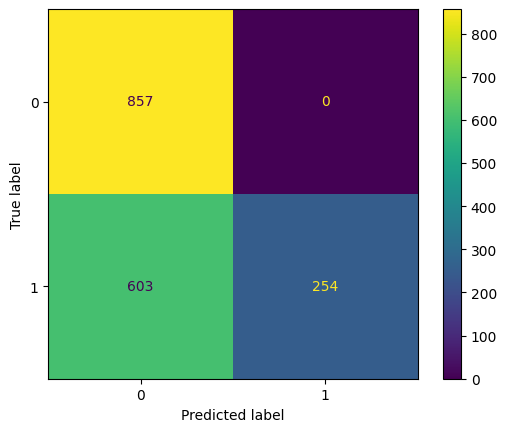

Precision:  0.7934931506849315
Recall:  0.648191365227538
F1 Score:  0.5984977004390124


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support

cm = confusion_matrix(conc_final_truth_list, final_prediction_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

final_precision, final_recall, final_f1_score, _ = precision_recall_fscore_support(conc_final_truth_list, final_prediction_list, average='weighted')
print("Precision: ", final_precision)
print("Recall: ", final_recall)
print("F1 Score: ", final_f1_score)

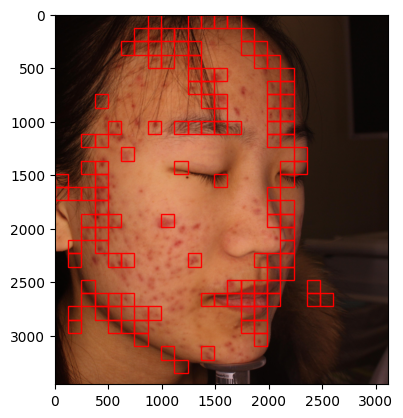

In [ ]:
target_size = (124, 124)
transform_app = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]);

testing_one_image = Image.open('/content/drive/MyDrive/APS360ProjectData/test/levle3_83_jpg.rf.ffb3718446b8538ee1f8d2d8ca1e24a8.jpg')

figure, axis = plt.subplots(1)
axis.imshow(testing_one_image)
patch_size = 124
for y in range(0, 3456 - patch_size + 1, 124):
  for x in range(0, 3112 - patch_size + 1, 124):
    current_patch_ = testing_one_image.crop((x, y, x + patch_size, y + patch_size))
    testing_this_p = transform_app(current_patch_)
    #model_trained_on_inter_lancoz
    probability = torch.sigmoid(final_model(testing_this_p))
    if(probability[0].item() > 0.35):
      continue
      #rectangle_box = patches.Rectangle((x,y,), 124, 124, linewidth=1, edgecolor='g', facecolor='none')
      #axis.add_patch(rectangle_box)
    else:
      rectangle_box = patches.Rectangle((x,y,), 124, 124, linewidth=1, edgecolor='r', facecolor='none')
      axis.add_patch(rectangle_box)

plt.show()


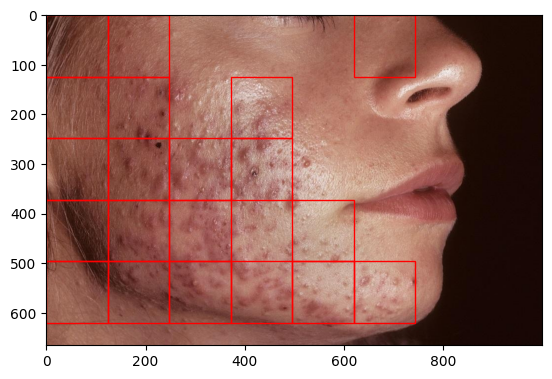

In [ ]:
target_size = (124, 124)
transform_app = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]);

testing_one_image = Image.open('/content/drive/MyDrive/APS360ProjectData/dataset_generated/test/Image_11_jpg.rf.4a40ae734d0a032fc602fbc31cd21884.jpg')

figure, axis = plt.subplots(1)
axis.imshow(testing_one_image)
patch_size = 124
for y in range(0, 3456 - patch_size + 1, 124):
  for x in range(0, 3112 - patch_size + 1, 124):
    current_patch_ = testing_one_image.crop((x, y, x + patch_size, y + patch_size))
    testing_this_p = transform_app(current_patch_)
    #model_trained_on_inter_lancoz
    probability = torch.sigmoid(final_model(testing_this_p))
    if(probability[0].item() > 0.35):
      continue
    else:
      rectangle_box = patches.Rectangle((x,y,), 124, 124, linewidth=1, edgecolor='r', facecolor='none')
      axis.add_patch(rectangle_box)

plt.show()

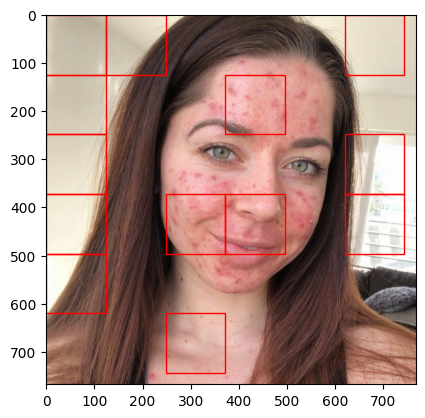

In [ ]:
#Image_117_JPEG.rf.51086ee15aea4a1571cf553c4a97dde2
target_size = (124, 124)
transform_app = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]);

testing_one_image = Image.open('/content/drive/MyDrive/APS360ProjectData/dataset_generated/test/Image_117_JPEG.rf.51086ee15aea4a1571cf553c4a97dde2.jpg')

figure, axis = plt.subplots(1)
axis.imshow(testing_one_image)
patch_size = 124
for y in range(0, 3456 - patch_size + 1, 124):
  for x in range(0, 3112 - patch_size + 1, 124):
    current_patch_ = testing_one_image.crop((x, y, x + patch_size, y + patch_size))
    testing_this_p = transform_app(current_patch_)
    #model_trained_on_inter_lancoz
    probability = torch.sigmoid(final_model(testing_this_p))
    if(probability[0].item() > 0.35):
      continue
    else:
      rectangle_box = patches.Rectangle((x,y,), 124, 124, linewidth=1, edgecolor='r', facecolor='none')
      axis.add_patch(rectangle_box)

plt.show()

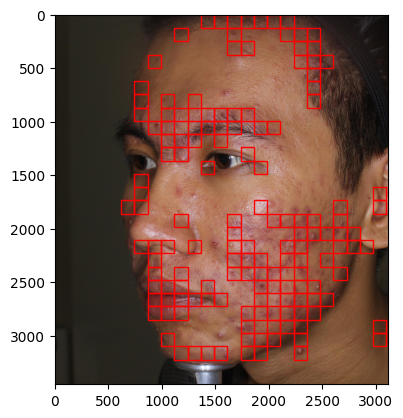

In [ ]:
#levle3_132_jpg.rf.3ee713b60b80de786823b183d1d680a9
#Image_117_JPEG.rf.51086ee15aea4a1571cf553c4a97dde2
target_size = (124, 124)
transform_app = transforms.Compose([transforms.Resize(target_size), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]);

testing_one_image = Image.open('/content/drive/MyDrive/APS360ProjectData/test/levle3_132_jpg.rf.3ee713b60b80de786823b183d1d680a9.jpg')

figure, axis = plt.subplots(1)
axis.imshow(testing_one_image)
patch_size = 124
for y in range(0, 3456 - patch_size + 1, 124):
  for x in range(0, 3112 - patch_size + 1, 124):
    current_patch_ = testing_one_image.crop((x, y, x + patch_size, y + patch_size))
    testing_this_p = transform_app(current_patch_)
    #model_trained_on_inter_lancoz
    probability = torch.sigmoid(final_model(testing_this_p))
    if(probability[0].item() > 0.33):
      continue
      #rectangle_box = patches.Rectangle((x,y,), 124, 124, linewidth=1, edgecolor='g', facecolor='none')
      #axis.add_patch(rectangle_box)
    else:
      rectangle_box = patches.Rectangle((x,y,), 124, 124, linewidth=1, edgecolor='r', facecolor='none')
      axis.add_patch(rectangle_box)

plt.show()
